In [1]:
# Master Project: Risk Analysis & Predictive Modeling
# Phase 1 - Python
# Notebook 01: Cleaning and EDA

In [2]:
# 1. Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RAW = Path("../00_Data/00_raw")
CLEAN = Path("../00_Data/01_clean")
CLEAN.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 50)

In [3]:
# 2. Load Raw Data

customers = pd.concat([
    pd.read_csv(RAW / "customers_part1.csv"),
    pd.read_csv(RAW / "customers_part2.csv")
], ignore_index=True)

financials = pd.concat([
    pd.read_csv(RAW / "financials_part1.csv"),
    pd.read_csv(RAW / "financials_part2.csv")
], ignore_index=True)

claims = pd.concat([
    pd.read_csv(RAW / "claims_part1.csv"),
    pd.read_csv(RAW / "claims_part2.csv")
], ignore_index=True)

print("Customers:", customers.shape)
print("Financials:", financials.shape)
print("Claims:", claims.shape)


Customers: (20000, 7)
Financials: (20000, 7)
Claims: (20000, 6)


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        20000 non-null  int64 
 1   name               20000 non-null  object
 2   age                20000 non-null  int64 
 3   income             20000 non-null  int64 
 4   employment_status  20000 non-null  object
 5   region             20000 non-null  object
 6   signup_date        20000 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


In [5]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      20000 non-null  int64 
 1   loan_amount      20000 non-null  int64 
 2   credit_score     20000 non-null  int64 
 3   late_payments    20000 non-null  int64 
 4   default_history  20000 non-null  int64 
 5   risk_score       20000 non-null  int64 
 6   risk_level       20000 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


In [6]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim_id       20000 non-null  int64 
 1   customer_id    20000 non-null  int64 
 2   incident_date  20000 non-null  object
 3   claim_amount   20000 non-null  int64 
 4   claim_status   20000 non-null  object
 5   claim_type     20000 non-null  object
dtypes: int64(3), object(3)
memory usage: 937.6+ KB


In [7]:
# 3. Basic Cleaning

# Strip whitespace and standardize text columns
for df in [customers, financials, claims]:
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str).str.strip()

# I am standardizing text values
customers["employment_status"] = customers["employment_status"].str.title()
customers["region"] = customers["region"].str.title()
claims["claim_status"] = claims["claim_status"].str.title()
claims["claim_type"] = claims["claim_type"].str.title()

# here, I have done dates formatting
customers["signup_date"] = pd.to_datetime(customers["signup_date"], errors="coerce")
claims["incident_date"] = pd.to_datetime(claims["incident_date"], errors="coerce")


C:\Users\HP\AppData\Local\Temp\ipykernel_1420\805631657.py:15: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  customers["signup_date"] = pd.to_datetime(customers["signup_date"], errors="coerce")


In [8]:
# 4. Known Data Issues

# negative incomes → setting it to NaN then I will impute
customers.loc[customers["income"] < 0, "income"] = np.nan
customers["income"] = customers.groupby("employment_status")["income"].transform(lambda s: s.fillna(s.median()))
customers["income"] = customers["income"].fillna(customers["income"].median())

# fixing credit score outliers
financials.loc[ (financials["credit_score"] < 300) | (financials["credit_score"] > 850), "credit_score"] = np.nan
financials["credit_score"] = financials.groupby("customer_id")["credit_score"].transform( lambda s: s.fillna(s.median()))
financials["credit_score"] = financials["credit_score"].fillna(financials["credit_score"].median())

# fixing negative claim amounts
claims["neg_claim_flag"] = claims["claim_amount"] < 0
claims["claim_amount"] = claims["claim_amount"].abs()


print(customers["income"].isna().sum())
print(financials["credit_score"].isna().sum())

0
0


In [9]:
# 5. General Validation

# age check
customers.loc[customers["age"] <= 0, "age"] = np.nan
customers["age"] = customers.groupby("region")["age"].transform(lambda s: s.fillna(s.median()))
customers["age"] = customers["age"].fillna(customers["age"].median())

# Late payments must be >=0
financials.loc[financials["late_payments"] < 0, "late_payments"] = 0

# I am handeling extreme values using quantile
for df, col in [(financials, "loan_amount"), (claims, "claim_amount")]:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)


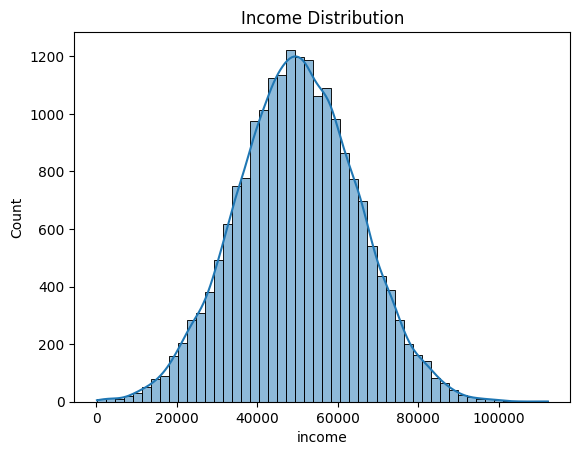

=== Income Distribution ===
Mean Income: 50004.03385
Median Income: 49962.5
=> The majority of customers earn around $50k annually
Min Income: 156.0
Max Income: 112218.0
Std Dev Income: 14871.52933162263
=> Moderate spread around the mean


In [98]:
# 6. Exploratory Data Analysis (EDA)

# Income distribution
sns.histplot(customers["income"], bins=50, kde=True)
plt.title("Income Distribution")
plt.show()

print("=== Income Distribution ===")
print("Mean Income:", customers["income"].mean())
print("Median Income:", customers["income"].median())
print("=> The majority of customers earn around $50k annually")

print("Min Income:", customers["income"].min())
print("Max Income:", customers["income"].max())
print("Std Dev Income:", customers["income"].std())
print("=> Moderate spread around the mean")

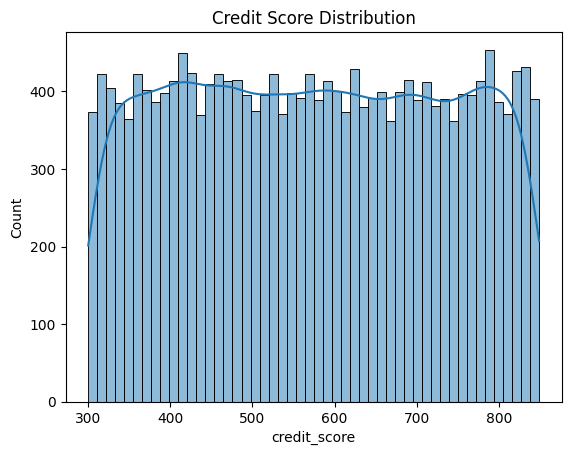

=== Credit Score Distribution ===
Mean Credit Score: 574.29035
Median Credit Score: 574.0
Fairly symmetric distribution
Min Credit Score: 300.0
Max Credit Score: 849.0
Std Dev Credit Score: 158.97811594350006
Credit scores are widely spread


In [99]:
# Credit score distribution
sns.histplot(financials["credit_score"], bins=50, kde=True)
plt.title("Credit Score Distribution")
plt.show()

print("=== Credit Score Distribution ===")
print("Mean Credit Score:", financials["credit_score"].mean())
print("Median Credit Score:", financials["credit_score"].median())
print("Fairly symmetric distribution")
print("Min Credit Score:", financials["credit_score"].min())
print("Max Credit Score:", financials["credit_score"].max())
print("Std Dev Credit Score:", financials["credit_score"].std())
print("Credit scores are widely spread")

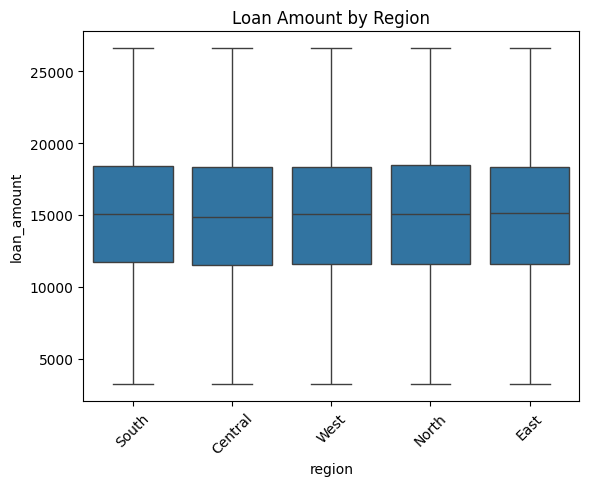

 Loan Amount by Region 
Central: count=4141, mean=14848.23, median=14836.00, min=3220.98, max=26611.17
East: count=3969, mean=14995.26, median=15117.00, min=3220.98, max=26611.17
North: count=4072, mean=14975.77, median=15067.00, min=3220.98, max=26611.17
South: count=4021, mean=15048.02, median=15092.00, min=3220.98, max=26611.17
West: count=3797, mean=14988.47, median=15077.00, min=3220.98, max=26611.17

Loan amounts are very similar across regions


In [71]:
# Loan amount by region
sns.boxplot(data=financials.merge(customers[["customer_id","region"]]),
            x="region", y="loan_amount")
plt.xticks(rotation=45)
plt.title("Loan Amount by Region")
plt.show()

merged_loans = financials.merge(customers[["customer_id", "region"]], on="customer_id")
print(" Loan Amount by Region ")
for region, grp in merged_loans.groupby("region"):
    print(f"{region}: count={grp.shape[0]}, mean={grp['loan_amount'].mean():.2f}, median={grp['loan_amount'].median():.2f}, min={grp['loan_amount'].min():.2f}, max={grp['loan_amount'].max():.2f}")
print("\nLoan amounts are very similar across regions")

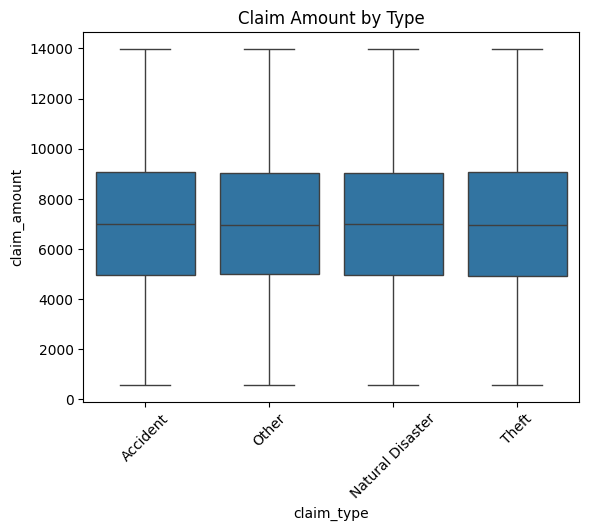

Claim Amount by Claim Type 
Accident: count=4971, mean=7023.61, median=7003.00, min=572.97, max=13980.12
Natural Disaster: count=4987, mean=7018.87, median=7007.00, min=572.97, max=13980.12
Other: count=5008, mean=7005.93, median=6970.00, min=572.97, max=13980.12
Theft: count=5034, mean=6990.18, median=6954.50, min=572.97, max=13980.12

Claim amounts are consistent across different claim types


In [70]:
# Claim amount by claim type
sns.boxplot(data=claims, x="claim_type", y="claim_amount")
plt.xticks(rotation=45)
plt.title("Claim Amount by Type")
plt.show()

# Claim amount by claim type
print("Claim Amount by Claim Type ")
for claim_type, grp in claims.groupby("claim_type"):
    print(f"{claim_type}: count={grp.shape[0]}, mean={grp['claim_amount'].mean():.2f}, median={grp['claim_amount'].median():.2f}, min={grp['claim_amount'].min():.2f}, max={grp['claim_amount'].max():.2f}")
print()

print("Claim amounts are consistent across different claim types")

In [69]:
# 7. Save Cleaned Outputs

customers.to_csv(CLEAN / "customers_clean.csv", index=False)
financials.to_csv(CLEAN / "financials_clean.csv", index=False)
claims.to_csv(CLEAN / "claims_clean.csv", index=False)

print("✅ Cleaned CSVs saved to:", CLEAN)

✅ Cleaned CSVs saved to: ..\00_Data\01_clean
